# Jump Diffusion Rolling VaR Backtesting (Poisson Jumps)

This notebook runs the same rolling 1-day VaR/ES backtest framework as the GBM baseline,
but upgrades the return model to include *Poisson jump risk* (rare large moves).

**Model idea (plain language):**
- Most days behave “normally” (diffusion / Brownian part)
- Some days include sudden jumps (crash/news shocks), modeled by a Poisson process

**Inputs**
Assumes `01_data_features.ipynb` already created:
- `data/processed/prices_returns.parquet`

**Outputs saved to Drive**
- `outputs/tables/jd_backtest_results.csv`
- `outputs/tables/jd_scorecard.csv`
- `outputs/figures/*` diagnostic plots (realized loss vs VaR, cumulative breaches)

**Why this notebook exists**
GBM often underestimates extreme losses (“fat tails”).
Jump Diffusion is a minimal extension using course material (Poisson process) to address that,
then we evaluate it using the same backtesting logic.


In [1]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [2]:
from pathlib import Path

PROJECT_NAME = "equity_var_backtesting"
BASE = Path("/content/drive/MyDrive") / PROJECT_NAME

DIRS = {
    "data_processed": BASE / "data" / "processed",
    "tables": BASE / "outputs" / "tables",
    "figures": BASE / "outputs" / "figures",
}

for p in DIRS.values():
    p.mkdir(parents=True, exist_ok=True)

DATA_PATH = DIRS["data_processed"] / "prices_returns.parquet"
DATA_PATH


PosixPath('/content/drive/MyDrive/equity_var_backtesting/data/processed/prices_returns.parquet')

In [3]:
!pip -q install pandas numpy pyarrow matplotlib


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 80)
plt.rcParams["figure.figsize"] = (12, 5)

TRADING_DAYS = 252
SEED = 42

WINDOW = 252           # rolling estimation window
N_PATHS = 10000        # dev: 5k-10k; final: 20k+
VAR_LEVELS = [0.95, 0.99]

# Jump identification settings (threshold method)
JUMP_K_SIGMA = 3.0     # defining "jump" as |return| > k * std(window)


In [6]:
df = pd.read_parquet(DATA_PATH)
df["date"] = pd.to_datetime(df["date"])
df.head()


,date,ticker,price,log_return,realized_vol_20d
0,2015-01-02,AAPL,24.237551,NaN,NaN
1,2015-01-05,AAPL,23.554741,-0.028576,NaN
2,2015-01-06,AAPL,23.556965,0.000094,NaN
3,2015-01-07,AAPL,23.887274,0.013924,NaN
4,2015-01-08,AAPL,24.805077,0.037702,NaN


In [7]:
#Building Wide log return matrix (date × ticker)
logret = df.pivot(index="date", columns="ticker", values="log_return").sort_index()
logret = logret.dropna(how="all")

TICKERS = sorted(logret.columns.tolist())
TICKERS


['AAPL', 'JPM', 'MSFT', 'SPY', 'TSLA', 'XOM']

In [8]:
#Helper: VaR / ES (loss convention)
def var_es_from_returns(simple_returns: np.ndarray, alpha=0.95):
    R = np.asarray(simple_returns)
    L = -R
    VaR = np.quantile(L, alpha)
    ES = L[L >= VaR].mean()
    return float(VaR), float(ES)


In [9]:
#Jump Diffusion calibration
def calibrate_jump_diffusion_threshold(log_returns_window: np.ndarray,
                                       trading_days=252,
                                       k_sigma=3.0):
    """
    Practical calibration:
    1) compute window std
    2) label jump days: |r| > k * std
    3) estimate jump frequency lambda (per year)
    4) estimate jump size mean/std from jump returns
    5) estimate diffusion mu/sigma from non-jump returns

    Returns annualized mu, sigma, and jump params (lambda, muJ, sigmaJ)
    """
    r = np.asarray(log_returns_window)
    r = r[~np.isnan(r)]
    if len(r) < 30:
        raise ValueError("Not enough data in window for calibration.")

    sig_daily = r.std(ddof=1)
    threshold = k_sigma * sig_daily

    is_jump = np.abs(r) > threshold
    jump_r = r[is_jump]
    diff_r = r[~is_jump]

    # Jump intensity (annualized)
    jump_prob = len(jump_r) / len(r)
    lam = jump_prob * trading_days  # expected jumps per year

    # Jump size distribution (log-return jump size)
    if len(jump_r) >= 2:
        muJ = jump_r.mean()
        sigJ = jump_r.std(ddof=1)
    elif len(jump_r) == 1:
        muJ = float(jump_r[0])
        sigJ = float(sig_daily)  # fallback
    else:
        muJ = 0.0
        sigJ = float(sig_daily)  # fallback

    # Diffusion part from non-jump days
    if len(diff_r) >= 2:
        mu_daily = diff_r.mean()
        sig_daily_diff = diff_r.std(ddof=1)
    else:
        mu_daily = r.mean()
        sig_daily_diff = r.std(ddof=1)

    mu = mu_daily * trading_days
    sigma = sig_daily_diff * np.sqrt(trading_days)

    return {
        "mu_annual": float(mu),
        "sigma_annual": float(sigma),
        "lambda_annual": float(lam),
        "muJ": float(muJ),
        "sigmaJ": float(sigJ),
        "jump_threshold": float(threshold),
        "n_jumps": int(len(jump_r)),
        "window_len": int(len(r))
    }


In [10]:
#Jump Diffusion simulator for 1-day simple returns
#Model in plain terms: diffusion (GBM-like) every day, plus a jump term: number of jumps ~ Poisson(λ dt); each jump size ~ Normal(muJ, sigmaJ)

def simulate_jump_diffusion_1d_returns(params: dict,
                                      n_paths=10000,
                                      seed=42,
                                      trading_days=252):
    """
    Simulate 1-day simple returns under Jump Diffusion.
    """
    rng = np.random.default_rng(seed)
    dt = 1 / trading_days

    mu = params["mu_annual"]
    sigma = params["sigma_annual"]
    lam = params["lambda_annual"]
    muJ = params["muJ"]
    sigJ = params["sigmaJ"]

    # Diffusion part (log return)
    Z = rng.standard_normal(n_paths)
    diff_log = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z

    # Jump count per path
    K = rng.poisson(lam * dt, size=n_paths)

    # Jump size: sum of K normals; approx by Normal(K*muJ, sqrt(K)*sigJ)
    # (Works because sum of normals is normal; conditional on K)
    jump_log = np.zeros(n_paths)
    idx = K > 0
    if idx.any():
        jump_log[idx] = rng.normal(loc=K[idx] * muJ, scale=np.sqrt(K[idx]) * sigJ)

    total_log = diff_log + jump_log
    return np.exp(total_log) - 1.0


In [11]:
#Rolling backtest - Jump Diffusion
#Matches notebook 02 structure for later comparison.
def backtest_jump_diffusion_single_ticker(logret_series: pd.Series,
                                          window=252,
                                          var_levels=(0.95, 0.99),
                                          n_paths=10000,
                                          seed=42,
                                          trading_days=252,
                                          k_sigma=3.0):
    r = logret_series.dropna().copy()
    dates = r.index

    rng = np.random.default_rng(seed)
    rows = []

    for i in range(window, len(r) - 1):
        train = r.iloc[i-window:i].values
        realized_log = float(r.iloc[i+1])

        params = calibrate_jump_diffusion_threshold(
            train,
            trading_days=trading_days,
            k_sigma=k_sigma
        )

        day_seed = int(rng.integers(1, 1_000_000))
        sim_R = simulate_jump_diffusion_1d_returns(
            params,
            n_paths=n_paths,
            seed=day_seed,
            trading_days=trading_days
        )

        realized_simple = np.exp(realized_log) - 1.0
        realized_loss = -realized_simple

        out = {
            "date": dates[i+1],
            "realized_logret": realized_log,
            "realized_simple_return": realized_simple,
            "realized_loss": realized_loss,

            # parameters (keep for transparency)
            "mu_annual": params["mu_annual"],
            "sigma_annual": params["sigma_annual"],
            "lambda_annual": params["lambda_annual"],
            "muJ": params["muJ"],
            "sigmaJ": params["sigmaJ"],
            "jump_threshold": params["jump_threshold"],
            "n_jumps_window": params["n_jumps"]
        }

        for a in var_levels:
            lvl = int(a * 100)
            VaR, ES = var_es_from_returns(sim_R, alpha=a)
            out[f"VaR_{lvl}"] = VaR
            out[f"ES_{lvl}"] = ES
            out[f"breach_{lvl}"] = bool(realized_loss > VaR)

        rows.append(out)

    return pd.DataFrame(rows)



In [12]:
#Jump Diffusion backtest for all tickers
bt_list = []
for tkr in TICKERS:
    series = logret[tkr]
    bt = backtest_jump_diffusion_single_ticker(
        series,
        window=WINDOW,
        var_levels=VAR_LEVELS,
        n_paths=N_PATHS,
        seed=SEED,
        trading_days=TRADING_DAYS,
        k_sigma=JUMP_K_SIGMA
    )
    bt["ticker"] = tkr
    bt["model"] = "JumpDiffusion"
    bt_list.append(bt)

jd_all = pd.concat(bt_list, ignore_index=True).sort_values(["ticker", "date"])
jd_all.head()


,date,realized_logret,realized_simple_return,realized_loss,mu_annual,sigma_annual,lambda_annual,muJ,sigmaJ,jump_threshold,n_jumps_window,VaR_95,ES_95,breach_95,VaR_99,ES_99,breach_99,ticker,model
0,2016-01-06,-0.019763,-0.019569,0.019569,-0.014628,0.243689,4.0,-0.001448,0.06574,0.050520,4,0.026544,0.037216,False,0.039005,0.061846,False,AAPL,JumpDiffusion
1,2016-01-07,-0.043121,-0.042205,0.042205,-0.011379,0.243328,4.0,-0.001448,0.06574,0.050459,4,0.025574,0.035031,True,0.037668,0.055943,True,AAPL,JumpDiffusion
2,2016-01-08,0.005274,0.005288,-0.005288,-0.031557,0.244139,4.0,-0.001448,0.06574,0.050596,4,0.025906,0.035587,False,0.039187,0.056638,False,AAPL,JumpDiffusion
3,2016-01-11,0.016062,0.016192,-0.016192,-0.089523,0.247538,4.0,-0.001448,0.06574,0.051172,4,0.026480,0.036096,False,0.038872,0.055500,False,AAPL,JumpDiffusion
4,2016-01-12,0.014409,0.014513,-0.014513,-0.122474,0.244592,4.0,-0.001448,0.06574,0.050671,4,0.026367,0.037299,False,0.038471,0.062605,False,AAPL,JumpDiffusion


In [13]:
out_jd = DIRS["tables"] / "jd_backtest_results.csv"
jd_all.to_csv(out_jd, index=False)
print("Saved:", out_jd)


Saved: /content/drive/MyDrive/equity_var_backtesting/outputs/tables/jd_backtest_results.csv


In [14]:
#Scorecard: breach rates vs expected
score_rows = []
for tkr in TICKERS:
    sub = jd_all[jd_all["ticker"] == tkr]
    n = len(sub)
    for a in VAR_LEVELS:
        lvl = int(a * 100)
        col = f"breach_{lvl}"
        score_rows.append({
            "ticker": tkr,
            "model": "JumpDiffusion",
            "var_level": a,
            "n_obs": n,
            "breaches": int(sub[col].sum()),
            "breach_rate": float(sub[col].mean()),
            "expected_rate": 1 - a
        })

jd_score = pd.DataFrame(score_rows).sort_values(["ticker", "var_level"])
display(jd_score)


,ticker,model,var_level,n_obs,breaches,breach_rate,expected_rate
0,AAPL,JumpDiffusion,0.95,2505,164,0.065469,0.05
1,AAPL,JumpDiffusion,0.99,2505,60,0.023952,0.01
2,JPM,JumpDiffusion,0.95,2505,141,0.056287,0.05
3,JPM,JumpDiffusion,0.99,2505,60,0.023952,0.01
4,MSFT,JumpDiffusion,0.95,2505,155,0.061876,0.05
5,MSFT,JumpDiffusion,0.99,2505,62,0.024750,0.01
6,SPY,JumpDiffusion,0.95,2505,153,0.061078,0.05
7,SPY,JumpDiffusion,0.99,2505,65,0.025948,0.01
8,TSLA,JumpDiffusion,0.95,2505,143,0.057086,0.05
9,TSLA,JumpDiffusion,0.99,2505,51,0.020359,0.01


In [15]:
out_score = DIRS["tables"] / "jd_scorecard.csv"
jd_score.to_csv(out_score, index=False)
print("Saved:", out_score)


Saved: /content/drive/MyDrive/equity_var_backtesting/outputs/tables/jd_scorecard.csv


In [17]:
#Plotting: realized loss vs VaR + breach dots
def plot_realized_vs_var(bt_df: pd.DataFrame, ticker: str, level: int = 99, model_name="JumpDiffusion"):
    sub = bt_df[bt_df["ticker"] == ticker].sort_values("date").copy()
    sub["date"] = pd.to_datetime(sub["date"])

    plt.figure(figsize=(12, 5))
    plt.plot(sub["date"], sub["realized_loss"], label="Realized loss (-return)", alpha=0.6)
    plt.plot(sub["date"], sub[f"VaR_{level}"], label=f"{model_name} VaR({level}%)", alpha=0.9)

    breaches = sub[sub[f"breach_{level}"]]
    plt.scatter(breaches["date"], breaches["realized_loss"], s=14, label="Breaches")

    plt.title(f"{ticker} — Realized loss vs {model_name} VaR({level}%)")
    plt.xlabel("date")
    plt.ylabel("loss")
    plt.legend()
    plt.tight_layout()
    plt.show()


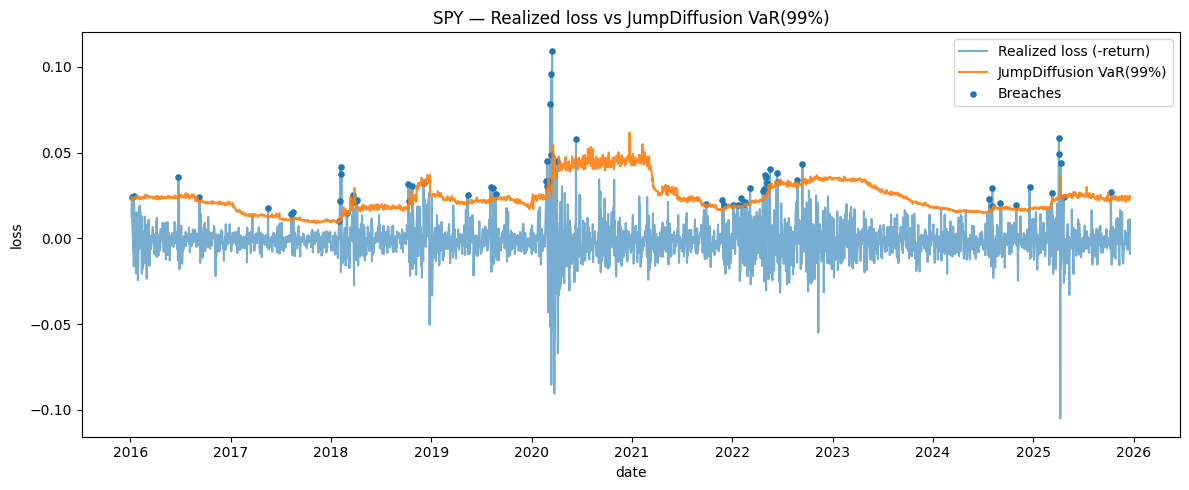

In [18]:
plot_realized_vs_var(jd_all, "SPY", 99, model_name="JumpDiffusion")


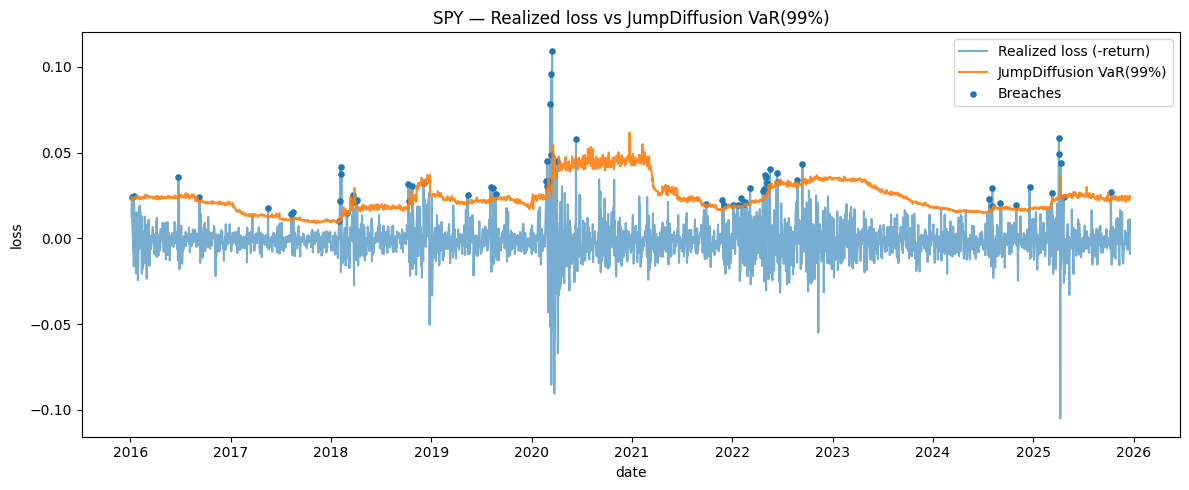

Saved figure: /content/drive/MyDrive/equity_var_backtesting/outputs/figures/SPY_JD_VaR99_realized_vs_var.png


In [19]:
def save_realized_vs_var(bt_df: pd.DataFrame, ticker: str, level: int, outpath: Path, model_name="JumpDiffusion"):
    sub = bt_df[bt_df["ticker"] == ticker].sort_values("date").copy()
    sub["date"] = pd.to_datetime(sub["date"])

    plt.figure(figsize=(12, 5))
    plt.plot(sub["date"], sub["realized_loss"], label="Realized loss (-return)", alpha=0.6)
    plt.plot(sub["date"], sub[f"VaR_{level}"], label=f"{model_name} VaR({level}%)", alpha=0.9)

    breaches = sub[sub[f"breach_{level}"]]
    plt.scatter(breaches["date"], breaches["realized_loss"], s=14, label="Breaches")

    plt.title(f"{ticker} — Realized loss vs {model_name} VaR({level}%)")
    plt.xlabel("date")
    plt.ylabel("loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    print("Saved figure:", outpath)

fig_path = DIRS["figures"] / "SPY_JD_VaR99_realized_vs_var.png"
save_realized_vs_var(jd_all, "SPY", 99, fig_path, model_name="JumpDiffusion")


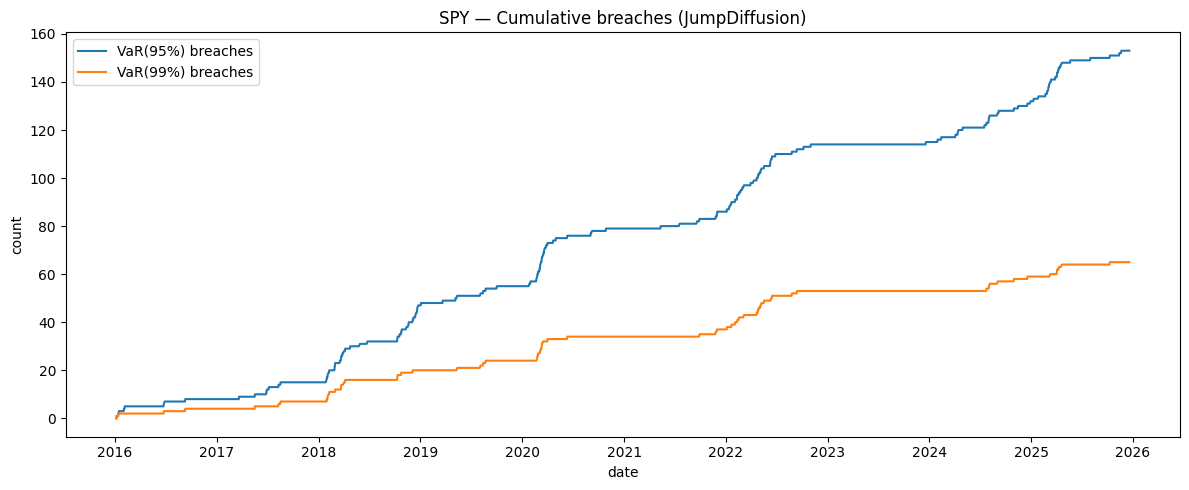

In [20]:
#Cumulative breaches plot (Jump Diffusion)
def plot_cumulative_breaches(bt_df: pd.DataFrame, ticker: str, var_levels=(0.95, 0.99), model_name="JumpDiffusion"):
    sub = bt_df[bt_df["ticker"] == ticker].sort_values("date").copy()
    sub["date"] = pd.to_datetime(sub["date"])

    plt.figure(figsize=(12, 5))
    for a in var_levels:
        lvl = int(a * 100)
        plt.plot(sub["date"], sub[f"breach_{lvl}"].cumsum(), label=f"VaR({lvl}%) breaches")
    plt.title(f"{ticker} — Cumulative breaches ({model_name})")
    plt.xlabel("date")
    plt.ylabel("count")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_cumulative_breaches(jd_all, "SPY", var_levels=VAR_LEVELS, model_name="JumpDiffusion")


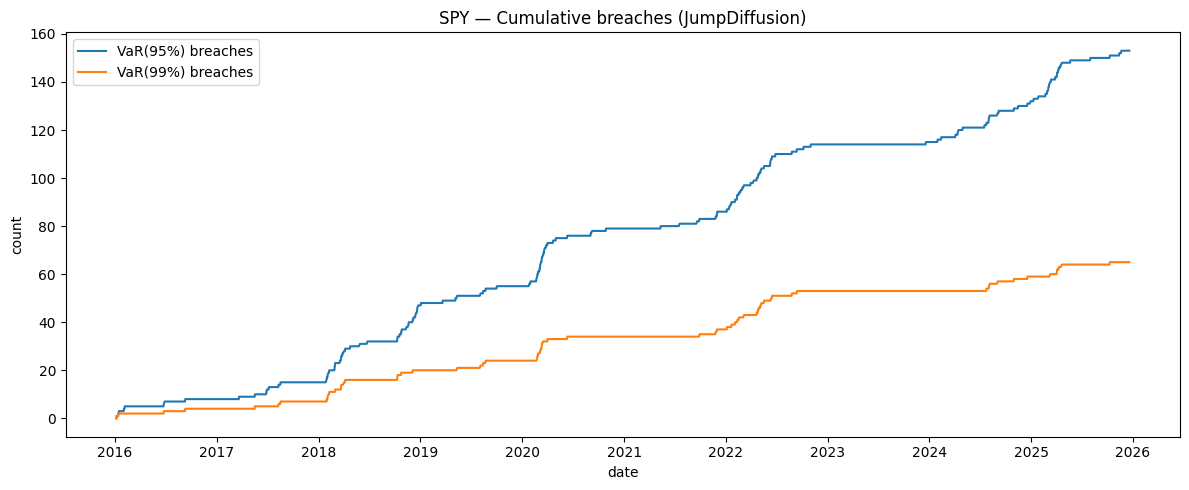

Saved figure: /content/drive/MyDrive/equity_var_backtesting/outputs/figures/SPY_JD_cumulative_breaches.png


In [21]:
def save_cumulative_breaches(bt_df: pd.DataFrame, ticker: str, outpath: Path, var_levels=(0.95, 0.99), model_name="JumpDiffusion"):
    sub = bt_df[bt_df["ticker"] == ticker].sort_values("date").copy()
    sub["date"] = pd.to_datetime(sub["date"])

    plt.figure(figsize=(12, 5))
    for a in var_levels:
        lvl = int(a * 100)
        plt.plot(sub["date"], sub[f"breach_{lvl}"].cumsum(), label=f"VaR({lvl}%) breaches")
    plt.title(f"{ticker} — Cumulative breaches ({model_name})")
    plt.xlabel("date")
    plt.ylabel("count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    print("Saved figure:", outpath)

cum_path = DIRS["figures"] / "SPY_JD_cumulative_breaches.png"
save_cumulative_breaches(jd_all, "SPY", cum_path, var_levels=VAR_LEVELS, model_name="JumpDiffusion")
